# Generando un tren de pulsos de radar pulsado

Un radar pulsado es aquel capaz de medir tanto rango (distancia) como velocidad, haciendo uso de la transmisión de pulsos muy cortos de duración τ y un periodo de escucha mayor Τ para luego leer el reflejo del mismo en alguna superficie. La distancia al objetivo se determina por el tiempo de ida y vuelta de la señal (en el caso estacionario) generando un Δ$t$, lo que nos permite utilizar la siguiente fómula:
 ### <center> $R = \frac{\Delta t*c}{2}$            
  Donde $R$ es el rango y $c$ es la velocidad de propagación de la onda, que al ser electromagnética corresponde a la velocidad de la luz. Con esta información y midiendo el $\Delta t$, podemos calcular una estimación del rango.

In [1]:
import adi
import time
import timeit
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import threading
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
from scipy.fftpack import fftfreq
from scipy.linalg import bandwidth

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.36"
SamplingRate     = 6e6        # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1          # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 918e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = 0           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 6e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize     = 2**20-1

Definimos variables como el PRI (pulse repetition interval) y su inversa, PRF (pulse repetition frequency). Por otro lado, determinamos la frecuencia de sampling y de transmisión dentro del pulso. El valor del PRI nos dará el rango máximo calculable por nuestro radar, ya que, nuestro pulso debe ser transmitido y recibido antes de volver a transmitir el segundo pulso. Es por esto que la máxima distancia calculable es:
  
$Max Range = \frac{c}{2}*PRI $.

En nuestro caso, la distancia máxima es de 150000 [m] o 150 [km] para un PRI de 0.001 [s] y una PRF de 1[kHz].

In [3]:
PRI = 0.001 #Se trata de un valor arbitrario, intervalo cada cuánto se repite el pulso (entre el inicio de un pulso y su antecesor)
PRF = 1/PRI #cantidad de pulsos por unidad de tiempo
potencia_señal = 1

pulses = 100 #cantidad de pulsos del radar

sample_f = SamplingRate
step = 1/SamplingRate #paso entre las muestras
f1 = 500e3
samples = pulses*int(PRI/step) # PRI/step cantidad de muestras que necesito para un PRI.

En esta porción de código calculamos la cantidad de $samples$ que vamos a utilizar, se obtiene de la división entre el intervalo de la repetición de pulsos y el paso entre las muestras, esto nos da la cantidad de muestras por pulso, luego, al multiplicarlo por la cantidad de pulsos del radar obtenemos la cantidad de muestras.

En las siguientes celdas generamos nuestra señal a transmitir ,nuestro vector de tiempo y se realiza la configuración de la SDR haciendo uso de la libreria adi. Modulamos el tren de pulsos con la siguiente función senoidal

\begin{equation}
    Tx_I = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx_Q = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx = Tx_I + jTx_Q = \sin(2* \pi * f_1 * t) + j * \sin(2* \pi * f_1 * t)
\end{equation}


In [4]:
t = np.linspace(0,(samples-1)*step,samples) #Genera el array de valores de tiempo (600.000 valores separados cada <step> unidades de tiempo)
pulse_length = 0.000005 #[s] => 0.5 duración del pulso en segundos
Tx_I = 20*np.sin(2*np.pi*f1*t) + 20
Tx_Q = 20*np.sin(2*np.pi*f1*t + np.pi/2) + 20
global zeros
zeros = np.zeros(len(t))  # arreglo completo
ones = np.ones(int(pulse_length*SamplingRate)) # señal continua de duracion pulse_length

for i in range(0,len(Tx_I),int(PRI*SamplingRate)):
      zeros[i:i+len(ones)] = ones #Cada un PRI, hacemos a la función zeros igual a 1 durante un tiempo <pulse_length> (es decir tenemos un tren de pulsos)
        
zerosOG = zeros

/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


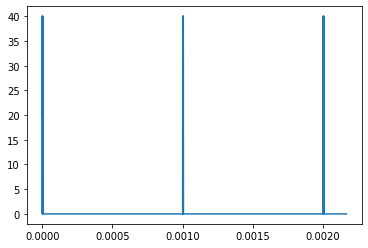

In [5]:
Tx_I = Tx_I * zeros # parte real de la señal
Tx_Q = Tx_Q * zeros #parte imaginaria
Tx = Tx_I + 1j * Tx_Q #señal completa

plt.plot(t[:13000],Tx[:13000])

In [6]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = True
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

Tramisión y Recepción

In [7]:
Loopback        = 1  
sdr.loopback    = Loopback
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()
global trim
trim = 0
global picture
global rxSignal
global rxSignalPic
global zeros
global zerosPic
global rxTime
picture = False

# Función para la transmisión en un hilo
def transmitir():
        sdr.tx(Tx * ((2**15-1)))        
# Función para la recepción en un hilo
def recibir1():
    global rxSignal
    global rxTime
    rxSignal = sdr.rx() / ((2**15-1))  
    rxTime = time.time()
        
stimationDelay = []
lenght = 1000

for l in range(lenght): 
    
    sdr.rx_destroy_buffer()
    sdr.tx_destroy_buffer()
    # Crea los hilos
    thread_tx = threading.Thread(target=transmitir)
    thread_rx1 = threading.Thread(target=recibir1)

    # Inicia los hilos
    thread_rx1.start()
    thread_tx.start()

    # Espera a que los hilos terminen 
    
    thread_rx1.join()
    thread_tx.join()


    trim = np.nonzero(rxSignal)[0][0]
    print(trim/SamplingRate)
    stimationDelay.append(trim/SamplingRate)
    print(l)
       



0.06291
0
0.043318666666666665
1
0.040363166666666665
2
0.047093666666666666
3
0.008591166666666667
4
0.043708666666666667
5
0.03522366666666667
6
0.029196666666666666
7
0.032247333333333336
8
0.051486
9
0.04558683333333333
10
0.040454
11
0.034770666666666665
12
0.051193166666666665
13
0.03393483333333333
14
0.04473933333333333
15
0.0380485
16
0.05309116666666667
17
0.038963333333333336
18
0.0330005
19
0.04075433333333333
20
0.038185333333333335
21
0.035032
22
0.038234833333333336
23
0.046573166666666665
24
0.038183666666666664
25
0.052838666666666666
26
0.046035
27
0.025353166666666666
28
0.046715
29
0.026409333333333333
30
0.03463683333333333
31
0.04035933333333333
32
0.046067833333333336
33
0.045191833333333334
34
0.0435125
35
0.032849166666666665
36
0.037088333333333334
37
0.05374383333333333
38
0.037602
39
0.04983816666666667
40
0.03762516666666667
41
0.0502625
42
0.03574133333333333
43
0.03748666666666667
44
0.052834
45
0.05180033333333333
46
0.03627483333333333
47
0.026442
48
0.

0.038713833333333336
393
0.037848
394
0.03187316666666667
395
0.051588166666666664
396
0.04358
397
0.027774666666666666
398
0.033439
399
0.037705666666666665
400
0.016958333333333332
401
0.03566883333333333
402
0.030564666666666667
403
0.035424333333333335
404
0.03499133333333333
405
0.0323245
406
0.0372515
407
0.054732166666666665
408
0.05143483333333333
409
0.055724166666666665
410
0.052826
411
0.03276
412
0.0522855
413
0.037317333333333334
414
0.0408935
415
0.035383333333333336
416
0.03806583333333333
417
0.0424625
418
0.0307545
419
0.037080166666666664
420
0.036554166666666665
421
0.050332666666666664
422
0.03827833333333333
423
0.03876216666666667
424
0.037823333333333334
425
0.042076
426
0.0557515
427
0.034088
428
0.03442233333333333
429
0.043262
430
0.029776
431
0.044749333333333335
432
0.049758833333333335
433
0.04430616666666667
434
0.030991666666666667
435
0.03740483333333333
436
0.052962
437
0.009816833333333334
438
0.03422616666666667
439
0.03356883333333333
440
0.035617
44

0.05075816666666667
782
0.055116
783
0.011387
784
0.03722266666666667
785
0.055936
786
0.05216
787
0.039808333333333334
788
0.054577
789
0.051327
790
0.0271735
791
0.038253333333333334
792
0.05684666666666666
793
0.04479366666666667
794
0.03631316666666667
795
0.03774333333333333
796
0.032628833333333336
797
0.0416815
798
0.05421683333333333
799
0.037379166666666665
800
0.0416175
801
0.05125316666666667
802
0.031015666666666667
803
0.03453133333333333
804
0.036274
805
0.051112
806
0.0427055
807
0.03973616666666667
808
0.04619683333333333
809
0.05098916666666667
810
0.039216666666666664
811
0.0504645
812
0.012731166666666667
813
0.03350416666666667
814
0.0427725
815
0.0524045
816
0.038262833333333336
817
0.038706
818
0.040576
819
0.05392483333333333
820
0.05545616666666667
821
0.03999833333333333
822
0.037818333333333336
823
0.035786
824
0.051443166666666665
825
0.052742
826
0.030993
827
0.031731666666666665
828
0.05098166666666667
829
0.034910166666666666
830
0.04283066666666667
831
0.

La media es: 0.03996603733333333
Varianza: 9.499449008310624e-05
Desviación Estándar: 0.009746511687937703


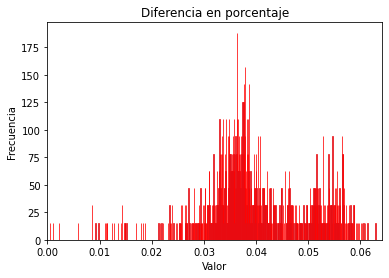

<Figure size 1800x1200 with 0 Axes>

In [11]:

print("La media es: " + str(np.mean(stimationDelay)))
varianza = np.var(stimationDelay)

# Calcula la desviación estándar
desviacion_estandar = np.std(stimationDelay)

print(f'Varianza: {varianza}')
print(f'Desviación Estándar: {desviacion_estandar}')

plt.hist(stimationDelay, bins=len(stimationDelay), density=True, alpha=0.75, edgecolor='red')

# Personalizar el gráfico
plt.title('Diferencia en porcentaje')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.xlim(0,max(stimationDelay))
# Ajustar la resolución
plt.figure(dpi=300)

# Mostrar el histograma
plt.show()